In [1]:
import asyncio
from os import getenv
from pathlib import Path
from shutil import copy, move

import nest_asyncio
import nibabel as nb
import nitransforms as nt
import numpy as np
from nipreps.synthstrip.wrappers.nipype import SynthStrip
from nipype.interfaces.afni import Volreg
from scipy.ndimage import binary_dilation
from skimage.morphology import ball

from nifreeze.registration import ants as erants

nest_asyncio.apply()

In [2]:
# Install test data from gin.g-node.org:
#   $ datalad install -g https://gin.g-node.org/nipreps-data/tests-nifreeze.git
# and point the environment variable TEST_DATA_HOME to the corresponding folder
DATA_PATH = Path(getenv("TEST_DATA_HOME", str(Path.home() / "nifreeze-tests")))
WORKDIR = Path.home() / "tmp" / "nifreezedev" / "ismrm25"
WORKDIR.mkdir(parents=True, exist_ok=True)

OUTPUT_DIR = Path.home() / "tmp" / "nifreezedev" / "ismrm25" / "nifreeze-ismrm25-exp2"
OUTPUT_DIR.mkdir(exist_ok=True, parents=True)

In [3]:
SAMPLE_LIST = DATA_PATH / "ismrm_sample.txt"

if not DATA_PATH.exists() or not SAMPLE_LIST.exists():
    raise SystemExit(
        "Required test data were not found under TEST_DATA_HOME. "
        "Download the ISMRM sample dataset as described in the README before running this notebook.",
    )


In [4]:
bold_runs = [
    Path(line)
    for line in SAMPLE_LIST.read_text().splitlines()
    if line.strip()
][:5]

missing_runs = [run for run in bold_runs if not (DATA_PATH.parent / run).exists()]
if missing_runs:
    missing = "\n".join(f"- {run}" for run in missing_runs)
    raise SystemExit(
        "One or more BOLD runs are missing. Fetch the dataset with datalad or curl (see README).\n"
        f"Missing files:\n{missing}",
    )


In [5]:
results = []
for bold_run in bold_runs:
    avg_path = OUTPUT_DIR / bold_run.parent / f"{bold_run.name.rsplit('_', 1)[0]}_boldref.nii.gz"

    if not avg_path.exists():
        nii = nb.load(DATA_PATH.parent / bold_run)
        average = nii.get_fdata().mean(-1)
        avg_path.parent.mkdir(exist_ok=True, parents=True)
        nii.__class__(average, nii.affine, nii.header).to_filename(avg_path)

    bmask_path = (
        OUTPUT_DIR / bold_run.parent / f"{bold_run.name.rsplit('_', 1)[0]}_label-brain_mask.nii.gz"
    )
    use_gpu = getenv("HAS_CUDA", "false").lower() == "true"
    if not bmask_path.exists():
        bmsk_results = SynthStrip(
            in_file=str(avg_path),
            model=Path("/opt") / "freesurfer" / "models" / "synthstrip.1.pt",
            use_gpu=use_gpu,
        ).run(cwd=str(WORKDIR))
        copy(bmsk_results.outputs.out_mask, bmask_path)

    dilmask_path = (
        avg_path.parent / f"{avg_path.name.rsplit('_', 1)[0]}_label-braindilated_mask.nii.gz"
    )

    if not dilmask_path.exists():
        niimsk = nb.load(bmask_path)
        niimsk.__class__(
            binary_dilation(niimsk.get_fdata() > 0.0, ball(4)).astype("uint8"),
            niimsk.affine,
            niimsk.header,
        ).to_filename(dilmask_path)

    oned_matrix_path = avg_path.parent / f"{avg_path.name.rsplit('_', 1)[0]}_desc-hmc_xfm.txt"
    realign_output = (
        avg_path.parent / f"{avg_path.name.rsplit('_', 1)[0]}_desc-realigned_bold.nii.gz"
    )

    if not realign_output.exists():
        volreg_results = Volreg(
            in_file=str(DATA_PATH.parent / bold_run),
            in_weight_volume=str(dilmask_path),
            args="-Fourier -twopass",
            zpad=4,
            outputtype="NIFTI_GZ",
            oned_matrix_save=f"{oned_matrix_path}.aff12.1D",
            out_file=str(realign_output),
            num_threads=12,
        ).run(cwd=str(WORKDIR))

        move(volreg_results.outputs.oned_matrix_save, oned_matrix_path)

In [6]:
afni_realigned = [
    OUTPUT_DIR / bold_run.parent / f"{bold_run.name.rsplit('_', 1)[0]}_desc-realigned_bold.nii.gz"
    for bold_run in bold_runs
]

In [7]:
afni_realigned

[PosixPath('/home/oesteban/tmp/nifreezedev/ismrm25/nifreeze-ismrm25-exp2/ds000005/sub-01/func/sub-01_task-mixedgamblestask_run-03_desc-realigned_bold.nii.gz'),
 PosixPath('/home/oesteban/tmp/nifreezedev/ismrm25/nifreeze-ismrm25-exp2/ds000005/sub-02/func/sub-02_task-mixedgamblestask_run-01_desc-realigned_bold.nii.gz'),
 PosixPath('/home/oesteban/tmp/nifreezedev/ismrm25/nifreeze-ismrm25-exp2/ds000005/sub-06/func/sub-06_task-mixedgamblestask_run-02_desc-realigned_bold.nii.gz'),
 PosixPath('/home/oesteban/tmp/nifreezedev/ismrm25/nifreeze-ismrm25-exp2/ds000005/sub-15/func/sub-15_task-mixedgamblestask_run-03_desc-realigned_bold.nii.gz'),
 PosixPath('/home/oesteban/tmp/nifreezedev/ismrm25/nifreeze-ismrm25-exp2/ds000005/sub-14/func/sub-14_task-mixedgamblestask_run-01_desc-realigned_bold.nii.gz')]

In [8]:
import pandas as pd
from matplotlib import pyplot as plt

from nifreeze.viz.motion_viz import plot_framewise_displacement


def plot_profile(image_path, axis=None, indexing=None, cmap="gray", label=None, figsize=(15, 1.7)):
    """Plots a single image slice on a given axis or a new figure if axis is None."""
    # Load the image
    image_data = nb.load(image_path).get_fdata()

    # Define default indexing if not provided
    if indexing is None:
        indexing = (
            image_data.shape[0] // 2,
            3 * image_data.shape[1] // 4,
            slice(None),
            slice(None),
        )

    # If no axis is provided, create a new figure and axis
    if axis is None:
        fig, axis = plt.subplots(figsize=figsize)
    else:
        fig = None  # If axis is provided, we won't manage the figure

    # Display the image on the specified axis with aspect='auto' and the colormap
    axis.imshow(image_data[indexing], aspect="auto", cmap=cmap)

    # Turn off the axis for a cleaner look
    axis.axis("off")

    if label:
        # Annotate the plot with the provided label
        axis.text(
            0.02,
            0.95,
            label,
            color="white",
            fontsize=12,
            ha="left",
            va="top",
            transform=axis.transAxes,
        )

    # If we created the figure, show it
    if fig is not None:
        plt.show()

    return fig


# def plot_combined_profile(images, indexing=None, figsize=(15, 1.7), cmap='gray', labels=None):
#     # Create a figure with three subplots in a vertical layout and specified figure size
#     n_images = len(images)

#     nplots = n_images * len(indexing or [True])
#     figsize = (figsize[0], figsize[1] * nplots)
#     fig, axes = plt.subplots(nplots, 1, figsize=figsize, constrained_layout=True)

#     if labels is None or isinstance(labels, str):
#         labels = (labels, ) * nplots

#     if indexing is None or len(indexing) == 0:
#         indexing = [None]

#     for i, idx in enumerate(indexing):
#         for j in range(len(images)):
#             ax = axes[i * n_images + j]
#             plot_profile(images[j], axis=ax, indexing=idx, cmap=cmap, label=labels[j])

#     return fig


def plot_combined_profile(
    images, afni_fd, nifreeze_fd, indexing=None, figsize=(15, 1.7), cmap="gray", labels=None
):
    # Calculate the number of profile plots
    n_images = len(images)
    nplots = n_images * len(indexing or [True])
    total_height = figsize[1] * nplots + 2  # Adjust figure height for FD plot

    # Create a figure with one extra row for the FD plot, setting `sharex=True` for shared x-axis
    fig, axes = plt.subplots(
        nplots + 1, 1, figsize=(figsize[0], total_height), constrained_layout=True, sharex=True
    )

    # Plot the framewise displacement on the first axis
    fd = pd.DataFrame({"afni": afni_fd, "nifreeze": nifreeze_fd})
    fd_axis = axes[0]
    _ = plot_framewise_displacement(fd, ["AFNI 3dVolreg FD", "nifreeze FD"], ax=fd_axis)

    # Set labels for profile plots if not provided
    if labels is None or isinstance(labels, str):
        labels = (labels,) * nplots

    # Set indexing if not provided
    if indexing is None or len(indexing) == 0:
        indexing = [None]

    # Plot each profile slice below the FD plot
    for i, idx in enumerate(indexing):
        for j in range(len(images)):
            ax = axes[i * n_images + j + 1]  # Shift index by 1 to account for FD plot
            plot_profile(images[j], axis=ax, indexing=idx, cmap=cmap, label=labels[j])

    return fig

In [9]:
from nifreeze.model.base import ExpectationModel
from nifreeze.utils.iterators import random_iterator

In [10]:
async def ants(t, data, hdr, nii, brainmask_path, semaphore, workdir):
    async with semaphore:
        # Set up paths
        fixed_path = workdir / f"fixedimage_{t:04d}.nii.gz"
        moving_path = workdir / f"movingimage_{t:04d}.nii.gz"

        # Create a mask for the specific timepoint
        t_mask = np.zeros(data.shape[-1], dtype=bool)
        t_mask[t] = True

        # Fit and predict using the model
        model = ExpectationModel()
        model.fit(
            data[..., ~t_mask],
            stat="median",
        )
        fixed_data = model.predict()

        # Save fixed and moving images
        nii.__class__(fixed_data, nii.affine, hdr).to_filename(fixed_path)
        nii.__class__(data[..., t_mask], nii.affine, hdr).to_filename(moving_path)

        # Generate the command
        cmdline = erants.generate_command(
            fixed_path,
            moving_path,
            fixedmask_path=brainmask_path,
            output_transform_prefix=f"conversion-{t:02d}",
            num_threads=8,
        ).cmdline

        # Run the command
        proc = await asyncio.create_subprocess_shell(
            cmdline,
            cwd=str(workdir),
            stdout=(workdir / f"ants-{t:04d}.out").open("w+"),
            stderr=(workdir / f"ants-{t:04d}.err").open("w+"),
        )
        returncode = await proc.wait()
        return returncode

In [11]:
# Set up concurrency limit and tasks
semaphore = asyncio.Semaphore(12)
tasks = []

# Load and preprocess data
for bold_run in bold_runs:
    print(bold_run.parent)
    workdir = WORKDIR / bold_run.parent
    workdir.mkdir(parents=True, exist_ok=True)
    data_path = DATA_PATH.parent / bold_run
    brainmask_path = (
        OUTPUT_DIR / bold_run.parent / f"{bold_run.name.rsplit('_', 1)[0]}_label-brain_mask.nii.gz"
    )

    nii = nb.load(data_path)
    hdr = nii.header.copy()
    hdr.set_sform(nii.affine, code=1)
    hdr.set_qform(nii.affine, code=1)
    data = nii.get_fdata(dtype="float32")
    n_timepoints = data.shape[-1]

    # Start tasks immediately upon creation
    for t in random_iterator(size=n_timepoints):  # Random iterator
        task = asyncio.create_task(ants(t, data, hdr, nii, brainmask_path, semaphore, workdir))
        tasks.append(task)

# Await all tasks
results = await asyncio.gather(*tasks, return_exceptions=True)

ds000005/sub-01/func
ds000005/sub-02/func
ds000005/sub-06/func
ds000005/sub-15/func
ds000005/sub-14/func


In [12]:
from nitransforms.resampling import apply

from nifreeze.registration.utils import compute_fd_from_transform

afni_fd = {}
nitransforms_fd = {}
# Load and preprocess data
for bold_run in bold_runs:
    work_path = WORKDIR / bold_run.parent

    n_timepoints = len(list(work_path.glob("*.mat")))

    xfms = [
        nt.linear.Affine(
            nt.io.itk.ITKLinearTransform.from_filename(
                work_path / f"conversion-{t:02d}0GenericAffine.mat"
            ).to_ras(
                reference=work_path / f"fixedimage_{t:04d}.nii.gz",
                moving=work_path / f"movingimage_{t:04d}.nii.gz",
            )
        )
        for t in range(n_timepoints)
    ]

    nii = nb.load(DATA_PATH.parent / bold_run)

    nitransforms_mapping = list(nt.linear.LinearTransformsMapping(xfms, reference=nii))
    nitransforms_fd[str(bold_run)] = np.array(
        [compute_fd_from_transform(nii, xfm) for xfm in nitransforms_mapping]
    )

    out_nitransforms = (
        OUTPUT_DIR
        / bold_run.parent
        / f"{bold_run.name.rsplit('_', 1)[0]}_desc-nitransforms_bold.nii.gz"
    )
    if not out_nitransforms.exists():
        resampled = np.zeros((*nii.shape[:3], n_timepoints), dtype=np.float32)
        for idx, xfm in enumerate(nitransforms_mapping):
            moving_frame = nb.Nifti1Image(
                np.asanyarray(nii.dataobj[..., idx], dtype=np.float32),
                nii.affine,
                nii.header,
            )
            resampled[..., idx] = np.asanyarray(
                apply(xfm, moving_frame, reference=nii).dataobj, dtype=np.float32
            )

        nb.Nifti1Image(resampled, nii.affine, nii.header).to_filename(out_nitransforms)

    afni_xfms = list(
        nt.linear.load(
            OUTPUT_DIR / bold_run.parent / f"{bold_run.name.rsplit('_', 1)[0]}_desc-hmc_xfm.txt"
        )
    )
    afni_fd[str(bold_run)] = np.array(
        [compute_fd_from_transform(nii, xfm) for xfm in afni_xfms]
    )

    out_afni = (
        OUTPUT_DIR / bold_run.parent / f"{bold_run.name.rsplit('_', 1)[0]}_desc-afni_bold.nii.gz"
    )
    if not out_afni.exists():
        afni_resampled = np.zeros((*nii.shape[:3], len(afni_xfms)), dtype=np.float32)
        for idx, xfm in enumerate(afni_xfms):
            moving_frame = nb.Nifti1Image(
                np.asanyarray(nii.dataobj[..., idx], dtype=np.float32),
                nii.affine,
                nii.header,
            )
            afni_resampled[..., idx] = np.asanyarray(
                apply(xfm, moving_frame, reference=nii).dataobj, dtype=np.float32
            )

        nb.Nifti1Image(afni_resampled, nii.affine, nii.header).to_filename(out_afni)


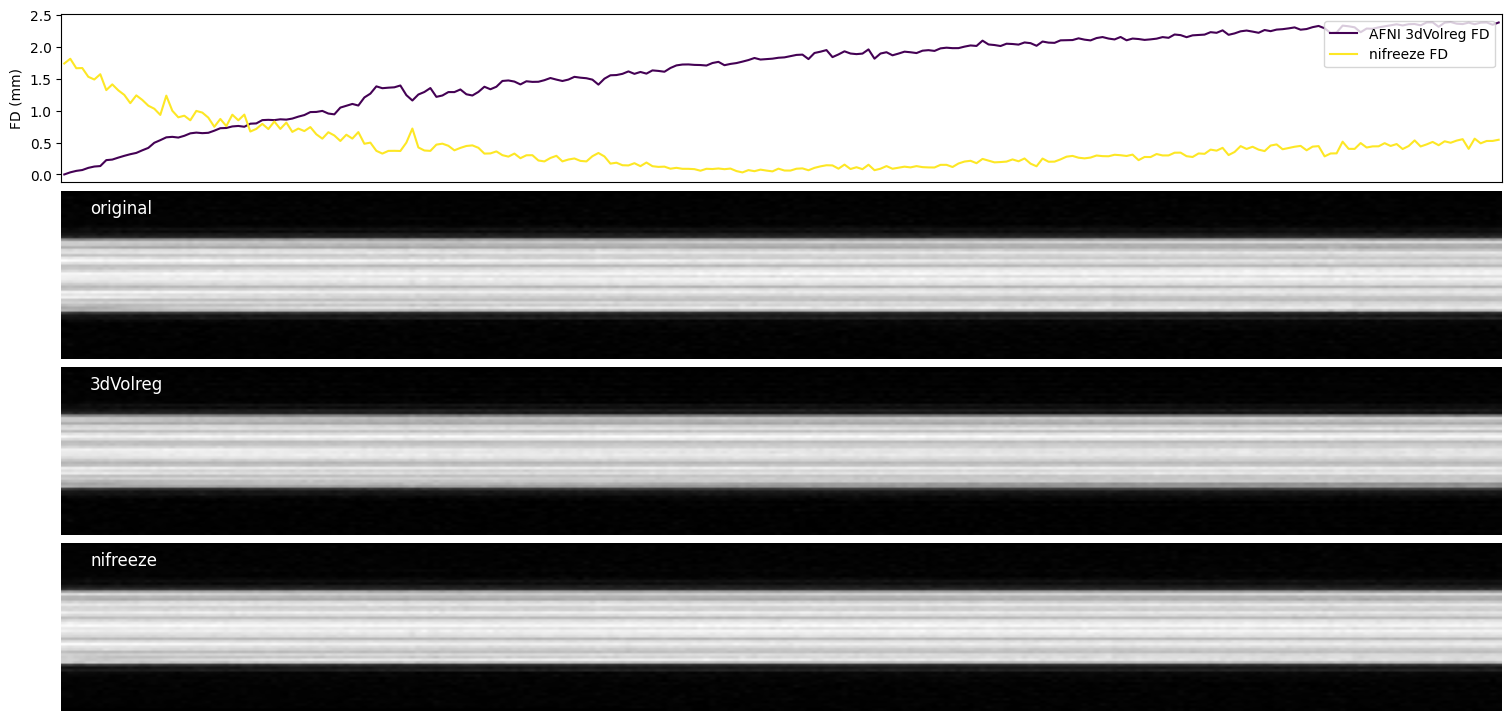

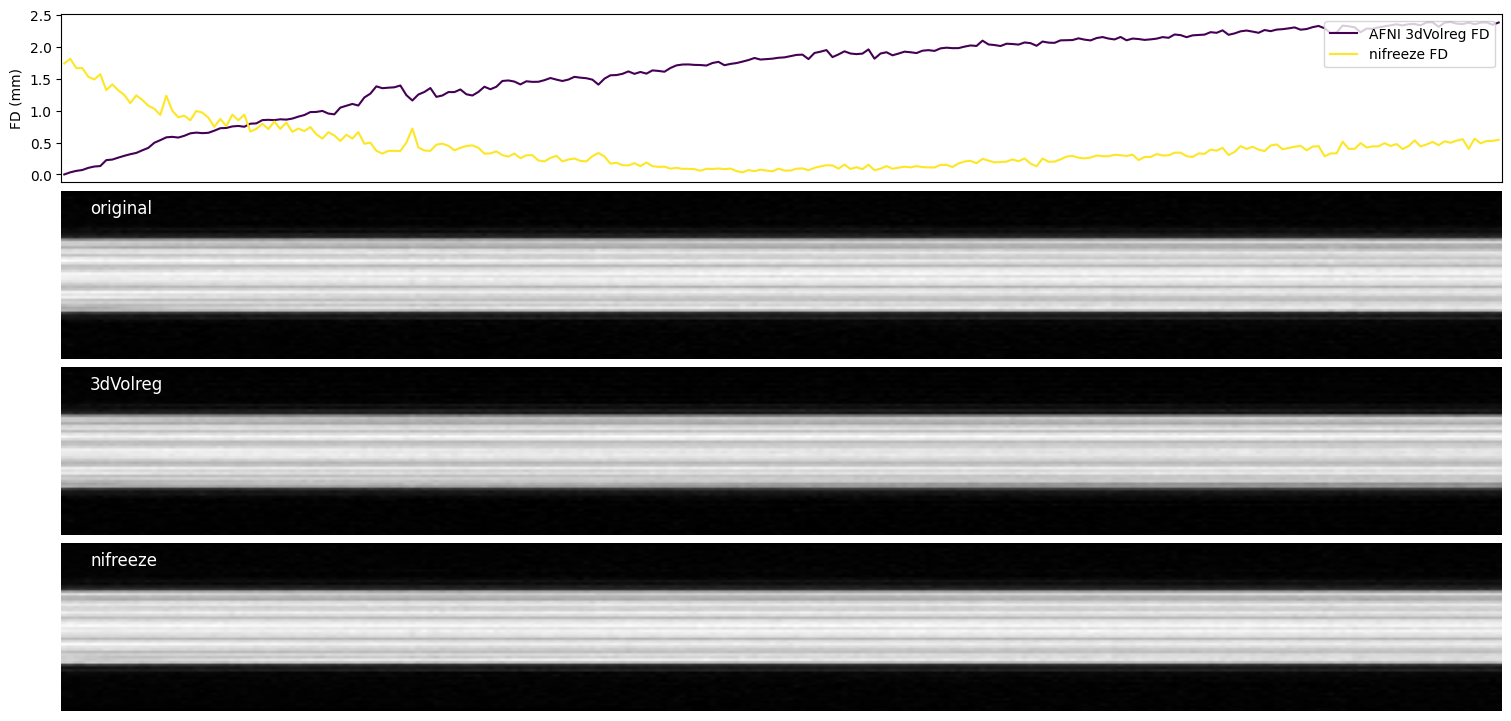

In [13]:
preview_run = bold_runs[3]
original_bold = DATA_PATH.parent / preview_run
afni_bold = OUTPUT_DIR / preview_run.parent / f"{preview_run.name.rsplit('_', 1)[0]}_desc-realigned_bold.nii.gz"
nitransforms_bold = OUTPUT_DIR / preview_run.parent / f"{preview_run.name.rsplit('_', 1)[0]}_desc-nitransforms_bold.nii.gz"

datashape = nb.load(original_bold).shape
plot_combined_profile(
    (original_bold, afni_bold, nitransforms_bold),
    afni_fd[str(preview_run)],
    nitransforms_fd[str(preview_run)],
    labels=("original", "3dVolreg", "nifreeze"),
    indexing=[(slice(None), 3 * datashape[1] // 4, datashape[2] // 2, slice(None))],
)


In [14]:
afni_fd

{'ds000005/sub-01/func/sub-01_task-mixedgamblestask_run-03_bold.nii.gz': array([0.        , 0.10793944, 0.0785538 , 0.18502803, 0.12220563,
        0.16872721, 0.14503551, 0.14865062, 0.18032092, 0.13341572,
        0.21312997, 0.14758788, 0.21596245, 0.17506971, 0.20783305,
        0.15595805, 0.20194852, 0.15876124, 0.20505767, 0.17766835,
        0.22369884, 0.18314381, 0.21593488, 0.17853102, 0.2290636 ,
        0.19049698, 0.24727104, 0.21113405, 0.24701779, 0.20155996,
        0.24296451, 0.20992624, 0.25803538, 0.25124535, 0.27384311,
        0.25425785, 0.25935209, 0.27905087, 0.27254567, 0.3148187 ,
        0.28138058, 0.27880982, 0.25465939, 0.29884672, 0.27027424,
        0.29357729, 0.26970486, 0.29885478, 0.24956244, 0.30005377,
        0.24795524, 0.2929522 , 0.23768644, 0.30652382, 0.24881218,
        0.29505506, 0.23743079, 0.30218118, 0.2416352 , 0.2904531 ,
        0.24481643, 0.26511555, 0.24801452, 0.2512896 , 0.24696861,
        0.25947683, 0.25438019, 0.26096119, 

In [15]:
# Generate an index.html with links to each SVG file
index_path = OUTPUT_DIR / "index.html"
with open(index_path, "w") as index_file:
    index_file.write("<html><body>\n")
    index_file.write("<h1>Profile Plot Index</h1>\n<ul>\n")

    for bold_run in bold_runs:
        original = DATA_PATH.parent / bold_run
        nitransforms = (
            OUTPUT_DIR
            / bold_run.parent
            / f"{bold_run.name.rsplit('_', 1)[0]}_desc-nitransforms_bold.nii.gz"
        )
        afni = (
            OUTPUT_DIR
            / bold_run.parent
            / f"{bold_run.name.rsplit('_', 1)[0]}_desc-realigned_bold.nii.gz"
        )

        datashape = nb.load(original).shape

        fig = plot_combined_profile(
            (original, afni, nitransforms),
            afni_fd[str(bold_run)],
            nitransforms_fd[str(bold_run)],
            labels=(str(bold_run), "3dVolreg", "nifreeze"),
            indexing=[None, (slice(None), 3 * datashape[1] // 4, datashape[2] // 2, slice(None))],
        )

        # Save the figure
        out_svg = OUTPUT_DIR / bold_run.parent / bold_run.name.replace(".nii.gz", ".svg")
        fig.savefig(out_svg, format="svg")
        fig.savefig(out_svg.with_suffix(".png"), format="png", dpi=320)
        plt.close(fig)

        index_file.write(f"<li><a href={out_svg.relative_to(OUTPUT_DIR)}>{bold_run}</a></li>\n")

    index_file.write("</ul>\n</body></html>")
